# Preliminary: Load Tweet and Price Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import re
import tweepy
import pandas as pd
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
from progressbar import ProgressBar
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
import matplotlib.pyplot as plt
lancaster=LancasterStemmer()
import pickle
import datetime as dt
import math
from sklearn.neighbors import KernelDensity
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#consumer key, consumer secret, access token, access secret from private Twitter Developer's account.
ckey="******************" #private info
csecret="*************************************************" #private info
atoken="**************************************************" #private info
asecret="********************************************" #private info

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

In [2]:
import pickle5 as pickle

pb = pickle.PickleBuffer(b"foo")
data = pickle.dumps(pb, protocol=5)
assert pickle.loads(data) == b"foo"

In [3]:
auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [4]:
# if file exists, read file
if os.path.isfile('text.pickle'):
    with open('text.pickle', 'rb') as text_handle:
        text = pickle.load(text_handle)
    with open('date.pickle', 'rb') as date_handle:
        date = pickle.load(date_handle)
# otherwise, crawl twitter data and write
else:
    pbar = ProgressBar()

    text = []
    date = []

    ticker_list = ["A","AFL","BA","CB","CCL","CDW","CERN","CI","COST","CTAS","CTVA","HD"]

    for ticker in pbar(ticker_list):
        single_text = []
        single_date = []
        for tweet_info in tweepy.Cursor(api.search,
                                   q='$'+ticker,
                                   count=100,
                                   result_type="recent",
                                   include_entities=True,
                                   lang="en",
                                   tweet_mode='extended',
                                   until='2020-12-12').items():
            if ('retweeted_status' in dir(tweet_info)) or (tweet_info.author.name=='stockbard'):
                continue
            else:
                single_text.append(tweet_info.full_text)
                single_date.append(tweet_info.created_at)
        text.append((ticker,single_text))
        date.append((ticker,single_date))

    text = dict(text)
    date = dict(date)
    
    with open('text.pickle', 'wb') as text_handle:
        pickle.dump(text, text_handle, protocol = pickle.HIGHEST_PROTOCOL)
    with open('date.pickle', 'wb') as date_handle:
        pickle.dump(date, date_handle, protocol = pickle.HIGHEST_PROTOCOL)

In [5]:
text['A']

['Eurozone shares -0.9% (-1.3% for wk)\nUS shares -0.1% (-1% wk)..up from lows on 1 wk funding bill averting shutdown,stimulus talks still stuck\nUS 10 yr yld -2bp to 0.89%\nOil -0.4% to $46.6\ngold +0.2% to $1839.3\nIron ore +1.2% (+9% wk)\nASX futures -0.02%\n$A 0.7537 w $US index +0.2% https://t.co/sg15X7kaPC',
 '$NTZ To Be Scooped Up In Cash And Stock Transaction By Unnamed Nasdaq Traded Company, Official PR Coming Next Week\nhttps://t.co/18fy8EY2vD\n\n$URBN $HYBE $EXPR $TRSI $A $CENX $DVMT $VOYA $SGSI $FNSR $CBI $ZEN $NYT',
 '$A Do we see $130.97 next? \xa02.28 % change recently https://t.co/yqrf3XQqN2',
 'What Warren Buffett Says About High-Profile IPOs Like Airbnb, DoorDash\n\nRelated Tickers: $ABNB $BRK $A $B $DASH $SNOW $UBER\nRead more at: https://t.co/L2pRD5QHxM',
 'Oversold on Hourly  \rhttps://t.co/2Hf0ZbjpKC \r$U  159.74  to 153.30 \r$GPN  194.99  to 192.99 \r$GE  11.41  to 11.15 \r$A  119.06  to 117.78 \r$COF  95.06  to 91.58 \r$AIG  39.87  to 38.76 \r$EOG  55.11  to 53.

In [6]:
price = pd.read_csv('Intraday_Price.csv')

In [7]:
price.TIME = ((price.TIME - 60000)/100).astype(int)

In [8]:
price

,TICKER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,A,20201201,930,117.580,118.380,117.080,117.08,56481
1,A,20201201,935,117.205,117.220,116.075,116.14,12413
2,A,20201201,940,116.030,116.350,115.730,115.73,8007
3,A,20201201,945,115.800,115.969,115.620,115.77,14472
4,A,20201201,950,115.890,116.520,115.840,116.33,25840
...,...,...,...,...,...,...,...,...
9056,SPY,20201211,1535,366.058,366.400,366.050,366.23,450454
9057,SPY,20201211,1540,366.235,366.530,366.090,366.13,698746
9058,SPY,20201211,1545,366.125,366.220,365.780,365.83,950815
9059,SPY,20201211,1550,365.830,366.185,365.710,366.05,1113516


In [9]:
def read_token(ticker):
    pbar = ProgressBar()
    twitter_CTVA = []
    token_CTVA = []
    date_CTVA = []
    time_CTVA = []
    for j in pbar(range(0, len(text[ticker]))):
        l = []
        trash = [0]
        text_tokens = word_tokenize(text[ticker][j])
        twitter_CTVA.append(text_tokens)
        for i in range(0, len(twitter_CTVA[j])):
            if trash[-1] == '$':
                trash.append('good')
            elif twitter_CTVA[j][i] == '$':
                trash.append(twitter_CTVA[j][i])
            elif ''.join(twitter_CTVA[j][i]).isalpha() and twitter_CTVA[j][i].lower() not in stopwords.words('english'):
                l.append(twitter_CTVA[j][i])
        token_CTVA.append(l)
        if date[ticker][j].day < 10:
            date_CTVA.append(str(date[ticker][j].year)+str(date[ticker][j].month)+'0'+str(date[ticker][j].day))
        else:
            date_CTVA.append(str(date[ticker][j].year)+str(date[ticker][j].month)+str(date[ticker][j].day))
        if date[ticker][j].minute < 10:  
            time_CTVA.append(str(date[ticker][j].hour)+'0'+str(date[ticker][j].minute))
        else:
            time_CTVA.append(str(date[ticker][j].hour)+str(date[ticker][j].minute))
    return token_CTVA, date_CTVA, time_CTVA

In [10]:
# all_token is a dictionary, key is ticker, value is tokens of all sentences for that ticker
pbar = ProgressBar()

ticker_list = ["A","AFL","BA","CB","CCL","CDW","CERN","CI","COST","CTAS","CTVA","HD"]

all_tokens = dict.fromkeys(ticker_list, None)
all_dates = dict.fromkeys(ticker_list, None)
all_times = dict.fromkeys(ticker_list, None)

for ticker in pbar(ticker_list):
    all_tokens[ticker] = read_token(ticker)[0]
    all_dates[ticker] = read_token(ticker)[1]
    all_times[ticker] = read_token(ticker)[2]

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

In [11]:
len(all_dates['A']) == len(all_times['A']) == len(all_tokens['A'])

True

# Part 1: Replicate the distribution of relative sentiment from Twitter

In [12]:
# Save all coumpounded score for each sentence under each twitter to all_intensity
# all_intensity[0] shows the coumpounded scores for each sentence of stock 'A'

CTVA_tokens = read_token('CTVA')

pbar = ProgressBar()

ticker_list = ["A","AFL","BA","CB","CCL","CDW","CERN","CI","COST","CTAS","CTVA","HD"]

all_intensity = []

# for i in pbar(range(0,len(ticker_list))):
    #text[ticker_list[i]] = re.sub(r"http\S+", "", text[ticker_list[i]]) # Remove URLs
    #x = deEmojify(text[ticker_list[i]]).split(".") # Use split by '.' to identify sentences
for cur_ticker in pbar(ticker_list):
    cur_tokens = all_tokens[cur_ticker]
    cur_intensity_list = []
    for j in range(0,len(cur_tokens)):
        cur_intensity_list.append(SentimentIntensityAnalyzer().polarity_scores(' '.join(cur_tokens[j]))['compound'])
    all_intensity.append(cur_intensity_list)
    

100% |########################################################################|
100% |########################################################################|


In [13]:
# sentiment score for each tweet of the first company
all_intensity[0]

[0.1531,
 0.0,
 0.0,
 0.3612,
 0.0,
 0.5574,
 -0.3182,
 0.2732,
 0.0,
 0.7506,
 0.5719,
 -0.2244,
 0.296,
 0.5849,
 0.4404,
 0.2732,
 0.7003,
 0.7269,
 0.4404,
 0.6705,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7351,
 0.0,
 0.4404,
 0.7003,
 0.2732,
 0.2023,
 0.5267,
 0.0,
 0.0,
 0.4939,
 -0.2023,
 -0.296,
 0.0,
 0.5859,
 0.7506,
 0.9766,
 0.5859,
 0.0,
 0.0,
 0.5994,
 0.296,
 0.0,
 0.0,
 0.0,
 0.0,
 0.296,
 0.0,
 0.0,
 -0.5423,
 0.0,
 0.6258,
 0.0,
 0.296,
 0.765,
 -0.296,
 -0.296,
 0.4404,
 0.34,
 0.34,
 0.0,
 -0.0404,
 0.2732,
 0.4404,
 0.0505,
 0.5106,
 0.5267,
 0.0,
 0.875,
 0.4588,
 -0.6597,
 0.34,
 0.0,
 0.0,
 0.0,
 0.34,
 0.0,
 0.34,
 0.34,
 0.34,
 0.34,
 0.0,
 0.34,
 -0.7184,
 0.0,
 0.0,
 0.0,
 0.0,
 0.296,
 0.0,
 0.4019,
 0.7564,
 -0.296,
 0.5766,
 0.2732,
 0.7783,
 0.7783,
 0.0,
 0.34,
 0.0,
 0.34,
 0.9042,
 0.4588,
 0.6249,
 0.296,
 0.6705,
 0.6244,
 0.4215,
 0.6249,
 0.2023,
 0.4404,
 0.8255,
 0.4939,
 0.8316,
 0.7089,
 0.7351,
 0.836,
 0.4939,
 0.6124,
 0.6124,
 0.0,
 0.4404,
 0.0

In [14]:
# corresponds to number of tweets of the third company
len(all_intensity[2])

2505

In [15]:
def kernel(ticker_list_num):
    grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.05, 0.5, 30)}, cv=5) # 10-fold cross-validation
    grid.fit(np.asarray(all_intensity[ticker_list_num])[:, None])
    #print(grid.best_params_)
    x_grid = np.linspace(-1.0, 1.0, 1000)
    kde = grid.best_estimator_
    pdf = np.exp(kde.score_samples(x_grid[:, None]))
    fig, ax = plt.subplots()
    ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
    #ax.hist(all_intensity[10], 30, fc='gray', histtype='stepfilled', alpha=0.3)
    ax.legend(loc='upper left')
    ax.set_xlim(-1.0, 1.0)
    plt.ylabel('Gaussian Kernel Density')
    plt.xlabel('Relative Sentiment from Twitter')
    plt.title("Twitter Sentiment Analysis for Stock " + ticker_list[ticker_list_num])
    plt.show()

### Part 1 Result -  Sentiment Kernel Density Distribution

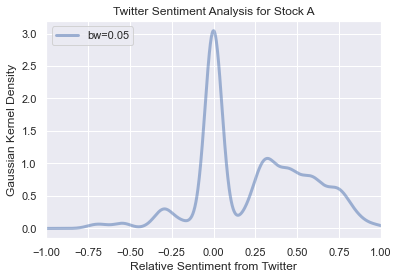

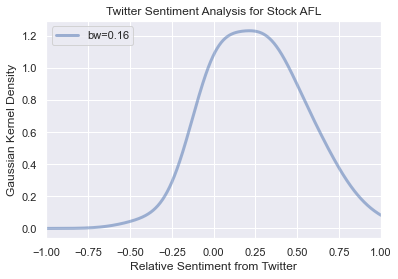

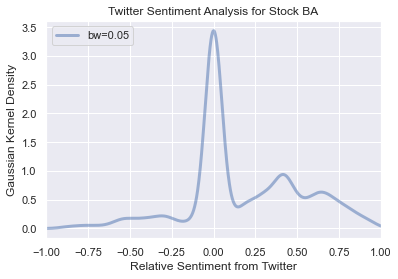

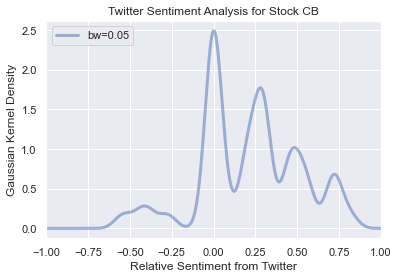

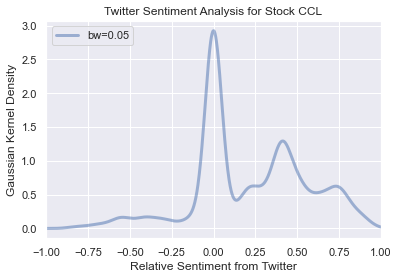

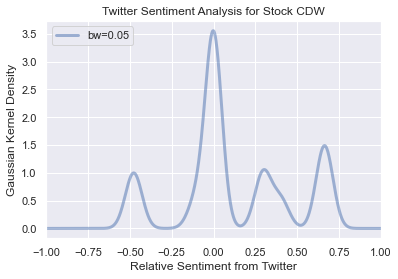

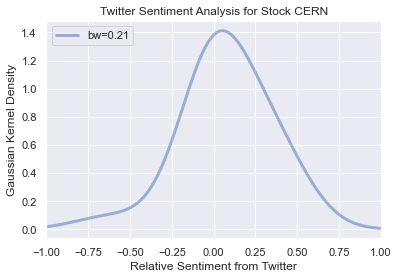

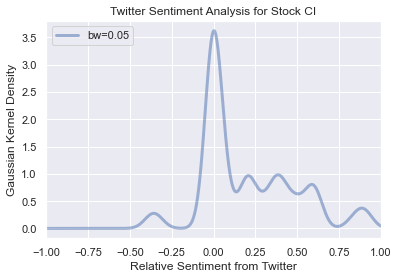

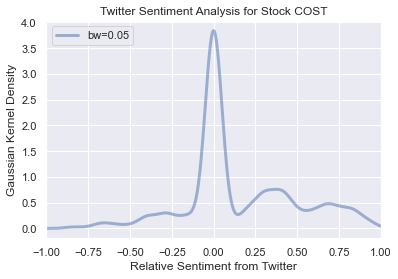

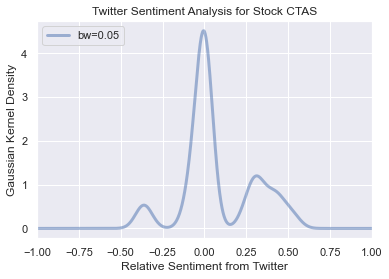

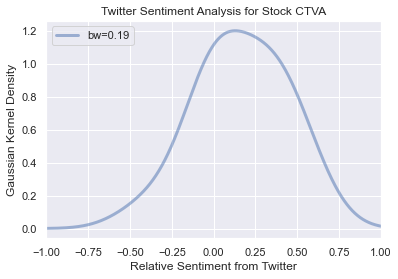

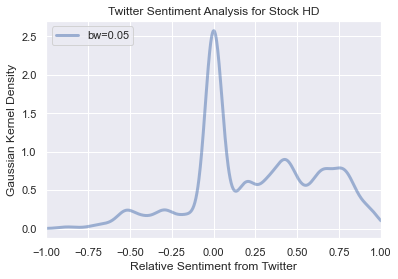

In [16]:
# replication of figure 2
for i in range(0,12):
    kernel(i)

# Part 2: Statistical Analysis Between Market and Twitter Sentiment

In [17]:
all_ticker = ["A","AFL","BA","CB","CCL","CDW","CERN","CI","COST","CTAS","CTVA","HD", "SPY"]

In [18]:
df = price
df

,TICKER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,A,20201201,930,117.580,118.380,117.080,117.08,56481
1,A,20201201,935,117.205,117.220,116.075,116.14,12413
2,A,20201201,940,116.030,116.350,115.730,115.73,8007
3,A,20201201,945,115.800,115.969,115.620,115.77,14472
4,A,20201201,950,115.890,116.520,115.840,116.33,25840
...,...,...,...,...,...,...,...,...
9056,SPY,20201211,1535,366.058,366.400,366.050,366.23,450454
9057,SPY,20201211,1540,366.235,366.530,366.090,366.13,698746
9058,SPY,20201211,1545,366.125,366.220,365.780,365.83,950815
9059,SPY,20201211,1550,365.830,366.185,365.710,366.05,1113516


In [19]:
df['SCORE'] = 0
df['NUM'] = 0

In [20]:
intensity = {}
count = 0
for i in all_dates.keys():
    intensity[i] = all_intensity[count]
    count+=1

In [21]:
#Create a dataframe to include all sentiment scores of each twitter
temp = []
dates = []
times = []
inten = []
label = []
for i in ticker_list:
    length = len(all_dates[i])
    label.extend([i]*length)
    dates.extend(all_dates[i])
    times.extend(all_times[i])
    inten.extend(intensity[i])
temp.append(label)
temp.append(dates)
temp.append(times)
temp.append(inten)
resources = pd.DataFrame(temp).transpose()
resources.columns = ['TICKER','DATE','TIME','SCORE']

In [22]:
resources["TIME"] = pd.to_numeric(resources["TIME"])
resources["DATE"] = pd.to_numeric(resources["DATE"])

In [23]:
resources[(resources['TICKER']=='A')]

,TICKER,DATE,TIME,SCORE
0,A,20201211,2144,0.1531
1,A,20201211,2102,0
2,A,20201211,2027,0
3,A,20201211,1905,0.3612
4,A,20201211,1831,0
...,...,...,...,...
202,A,20201206,1512,0
203,A,20201206,1155,0.2732
204,A,20201206,854,0.7506
205,A,20201206,852,0.0772


In [24]:
pbar = ProgressBar()
pd.options.mode.chained_assignment = None  # default='warn'
count = 0
for i in pbar(range(df.shape[0])):
    if df.iloc[i]['TIME'] == 930:
        ## calcuate the part of previous date, need to locate the day before
        from datetime import datetime, timedelta 
        s = df.iloc[i]['DATE']
        s = "{0:-08d}".format(s)
        date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
        date -= timedelta(days=1) ## move the date before
        date1 = date.strftime("%Y%m%d")
        
        low_bound1 = 1556
        upper_bound1 = 2359
        temp_sum1 = resources.loc[(resources['TICKER']== df.iloc[i]['TICKER'])&(resources['DATE']==date1)
                      &((resources['TIME']<=upper_bound1)&(resources['TIME']>=low_bound1))]['SCORE'].sum()
        temp_count1 = resources.loc[(resources['TICKER']== df.iloc[i]['TICKER'])&(resources['DATE']==date1)
                      &((resources['TIME']<=upper_bound1)&(resources['TIME']>=low_bound1))]['SCORE'].count()
        
        ## calcuate the part of current date
        low_bound2 = 0
        upper_bound2 = 930
        date2 = df.iloc[i]['DATE']
        temp_sum2 = resources.loc[(resources['TICKER']== df.iloc[i]['TICKER'])&(resources['DATE']==date2)
                      &((resources['TIME']<=upper_bound2)&(resources['TIME']>=low_bound2))]['SCORE'].sum()
        temp_count2 = resources.loc[(resources['TICKER']== df.iloc[i]['TICKER'])&(resources['DATE']==date2)
                      &((resources['TIME']<=upper_bound2)&(resources['TIME']>=low_bound2))]['SCORE'].count()
        
        temp_sum = temp_sum1+temp_sum2
        temp_count = temp_count1+temp_count2
    else:
        low_bound = df.iloc[i]['TIME']-4
        upper_bound = df.iloc[i]['TIME']
        temp_sum = resources.loc[(resources['TICKER']== df.iloc[i]['TICKER'])&(resources['DATE']==df.iloc[i]['DATE'])
                      &((resources['TIME']<=upper_bound)&(resources['TIME']>=low_bound))]['SCORE'].sum()
        temp_count = resources.loc[(resources['TICKER']== df.iloc[i]['TICKER'])&(resources['DATE']==df.iloc[i]['DATE'])
                      &((resources['TIME']<=upper_bound)&(resources['TIME']>=low_bound))]['SCORE'].count()
        
    df.loc[i, 'SCORE'] = temp_sum
    df.loc[i, 'NUM'] = temp_count

# The most of the first hundreds rows are zero because there do not exist twitter messages from 20201201 to 20201206

100% |########################################################################|


In [25]:
df['AVE'] = df['SCORE']/df['NUM']

In [26]:
df[(df['SCORE']!=0)]

,TICKER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,SCORE,NUM,AVE
312,A,20201207,930,115.200,116.440,115.075,116.270,68973,4.5212,16,0.282575
379,A,20201207,1505,114.530,114.555,114.460,114.500,10743,0.2732,1,0.273200
382,A,20201207,1520,114.540,114.930,114.540,114.775,16089,0.2263,1,0.226300
383,A,20201207,1525,114.790,114.820,114.640,114.640,11832,0.6344,1,0.634400
389,A,20201207,1555,114.410,114.680,114.390,114.400,464165,0.2023,1,0.202300
...,...,...,...,...,...,...,...,...,...,...,...
8357,HD,20201211,1525,264.545,264.620,264.410,264.460,24621,0.2732,1,0.273200
8358,HD,20201211,1530,264.465,264.920,264.400,264.890,30540,0.4473,2,0.223650
8359,HD,20201211,1535,264.920,265.200,264.850,265.160,42528,0.1651,2,0.082550
8360,HD,20201211,1540,265.150,265.270,264.930,264.960,33824,-0.4215,1,-0.421500


In [27]:
df = df.set_index(['TICKER', 'DATE','TIME'])
df

OPEN     HIGH      LOW   CLOSE      VOL  SCORE  NUM  \
TICKER DATE     TIME                                                           
A      20201201 930   117.580  118.380  117.080  117.08    56481    0.0    0   
                935   117.205  117.220  116.075  116.14    12413    0.0    0   
                940   116.030  116.350  115.730  115.73     8007    0.0    0   
                945   115.800  115.969  115.620  115.77    14472    0.0    0   
                950   115.890  116.520  115.840  116.33    25840    0.0    0   
...                       ...      ...      ...     ...      ...    ...  ...   
SPY    20201211 1535  366.058  366.400  366.050  366.23   450454    0.0    0   
                1540  366.235  366.530  366.090  366.13   698746    0.0    0   
                1545  366.125  366.220  365.780  365.83   950815    0.0    0   
                1550  365.830  366.185  365.710  366.05  1113516    0.0    0   
                1555  366.040  366.360  365.850  366.14  4713915    0.0    0   

                      AVE  
TICKER DATE     TIME       
A      20201201 930   NaN  
                935   NaN  
                940   NaN  
                945   NaN  
                950   NaN  
...                   ...  
SPY    20201211 1535  NaN  
                1540  NaN  
                1545  NaN  
                1550  NaN  
                1555  NaN  

[9061 rows x 8 columns]

In [28]:
# compute excess return
# dictionary of dataframe contain price and volume
price_dict = dict.fromkeys(ticker_list, None)

df_SPY = df.loc['SPY']
df_SPY['SPY_LOG_RETURN'] = np.log(df_SPY.CLOSE) - np.log(df_SPY.CLOSE.shift(1))
df_SPY = df_SPY.drop(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL'], axis = 1)
df_SPY

for ticker in ticker_list:
    cur_df = df.loc[ticker]
    cur_df['LOG_RETURN'] = np.log(cur_df.CLOSE) - np.log(cur_df.CLOSE.shift(1))
    merge_df = cur_df.merge(df_SPY.drop(columns=['SCORE','NUM','AVE']), left_index=True, right_index=True)
    merge_df['EXCESS_RETURN'] = merge_df['LOG_RETURN'] - merge_df['SPY_LOG_RETURN']
    merge_df.drop(['LOG_RETURN', 'SPY_LOG_RETURN'], axis = 1, inplace = True)
    price_dict[ticker] = merge_df
    price_dict[ticker] = price_dict[ticker].fillna(0)
    price_dict[ticker] = price_dict[ticker].loc[int(min(all_dates[ticker])):,:]

### Part 2 Result - Sentiment's Impact on Excess Return, Volume, and Volatility

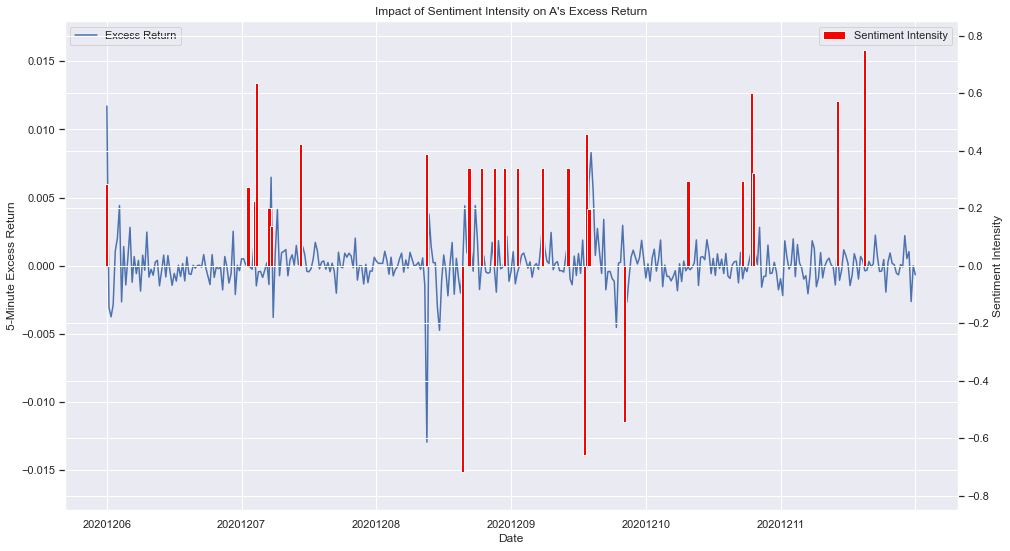

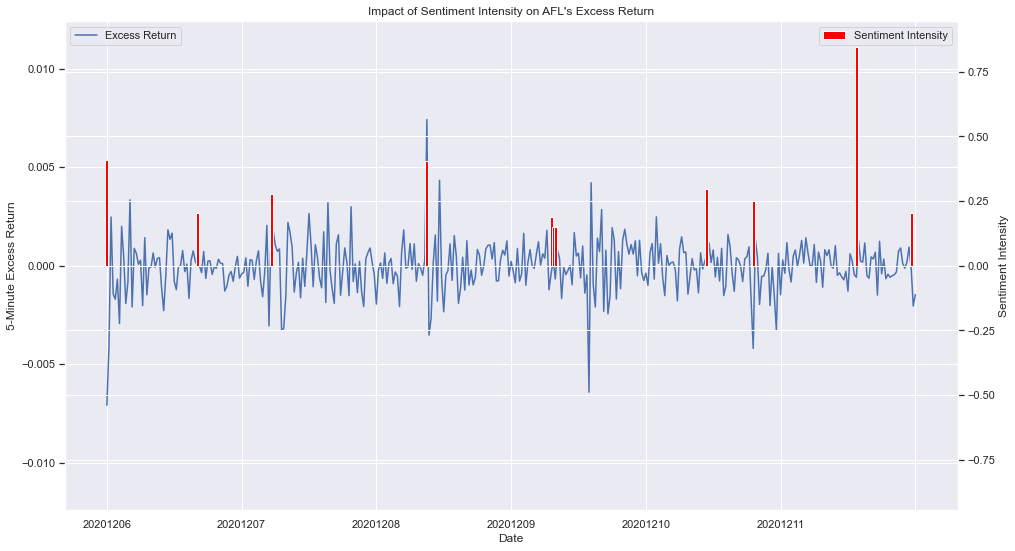

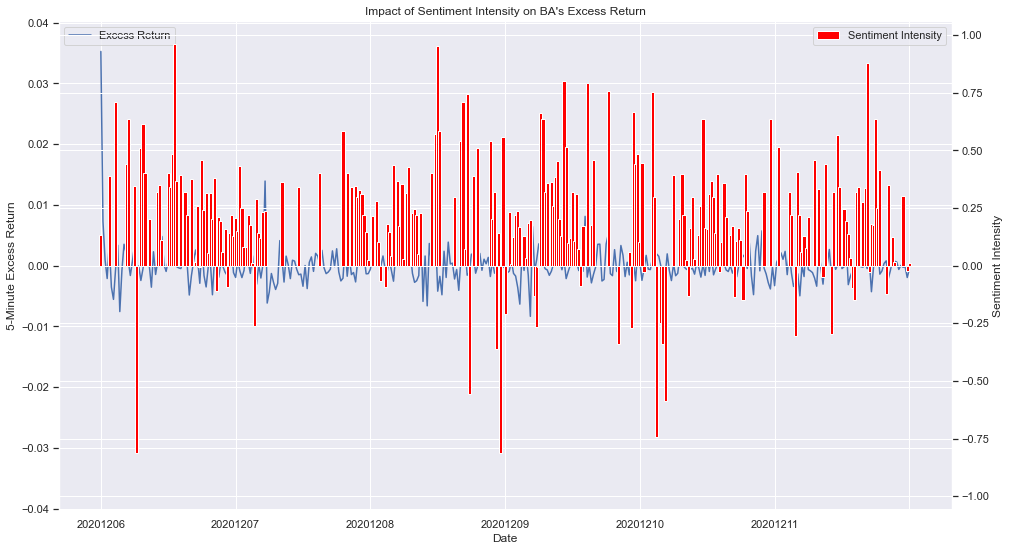

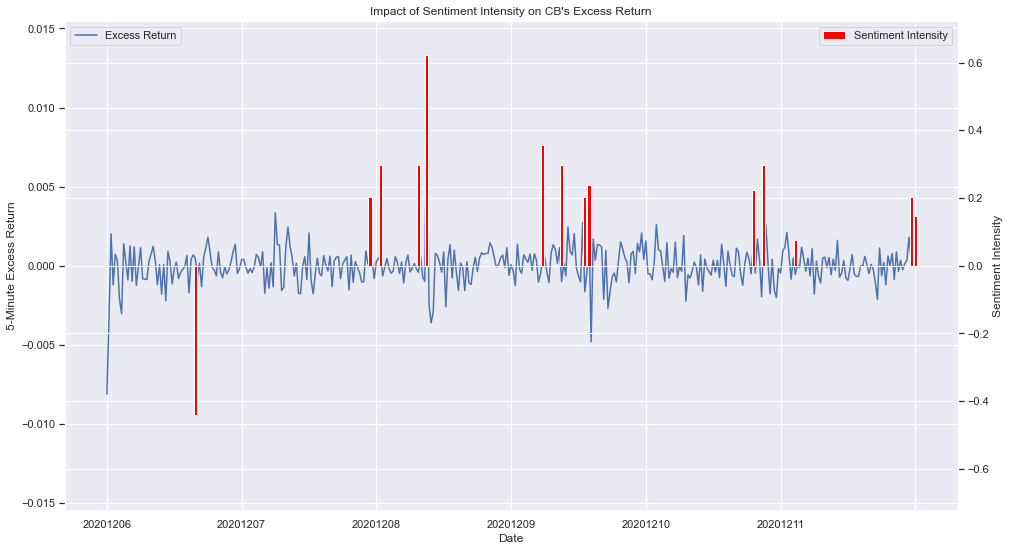

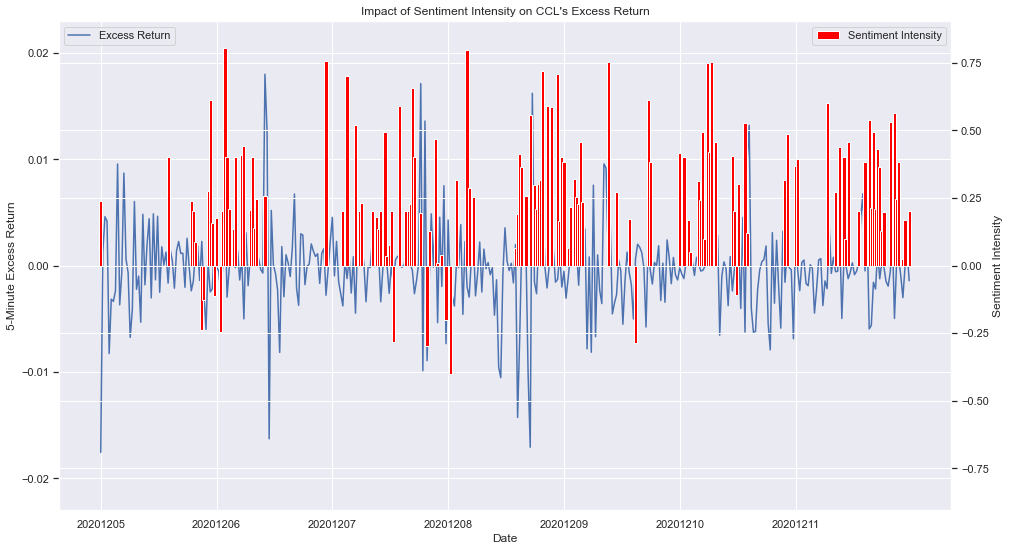

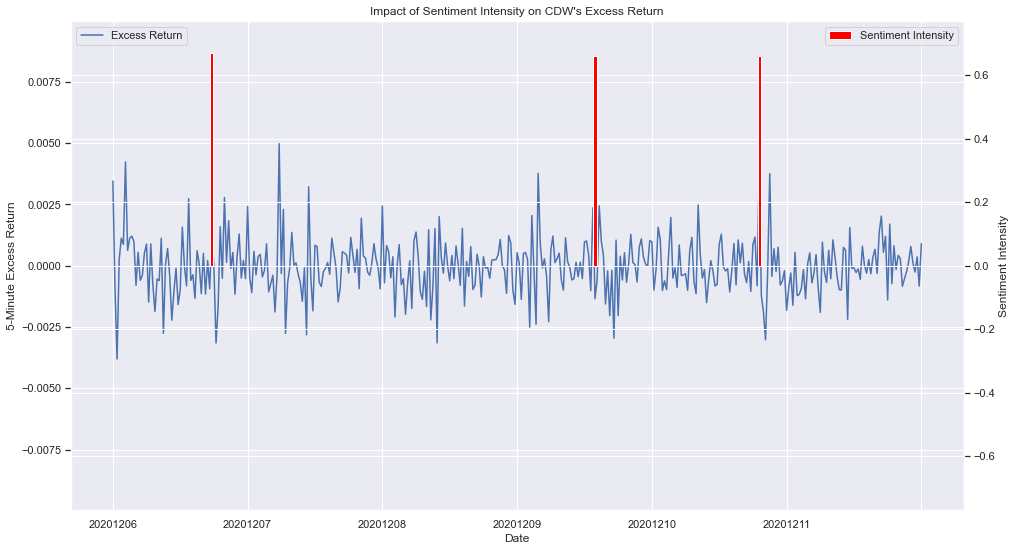

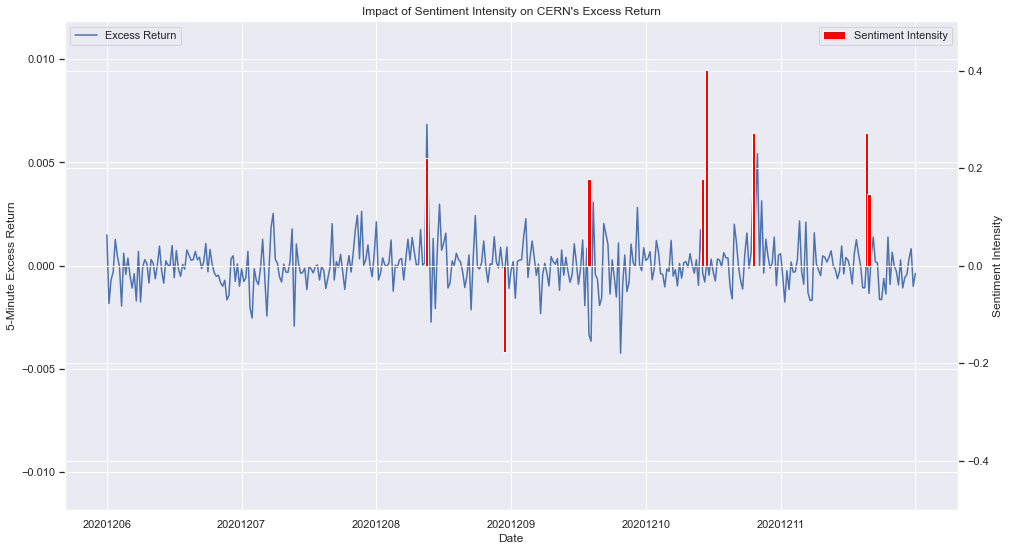

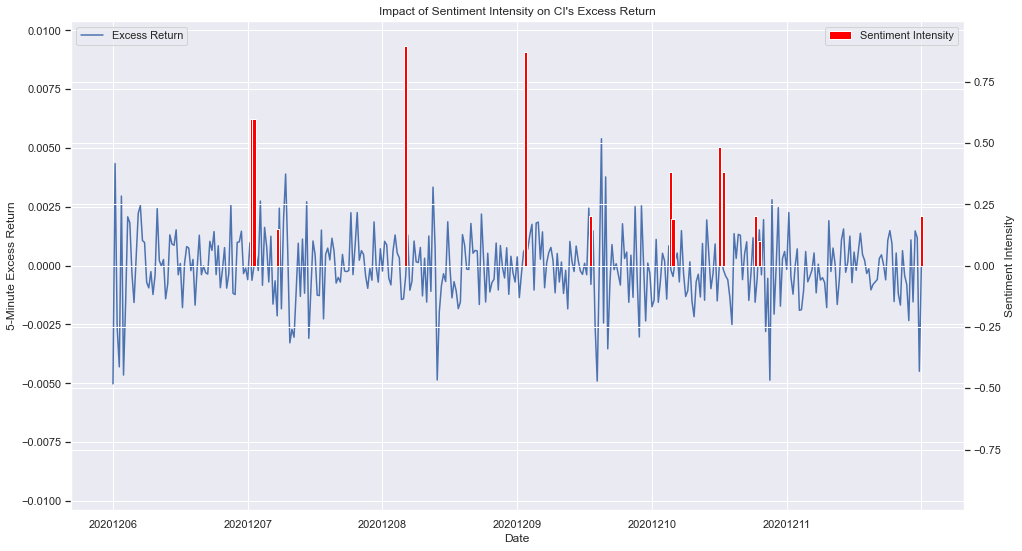

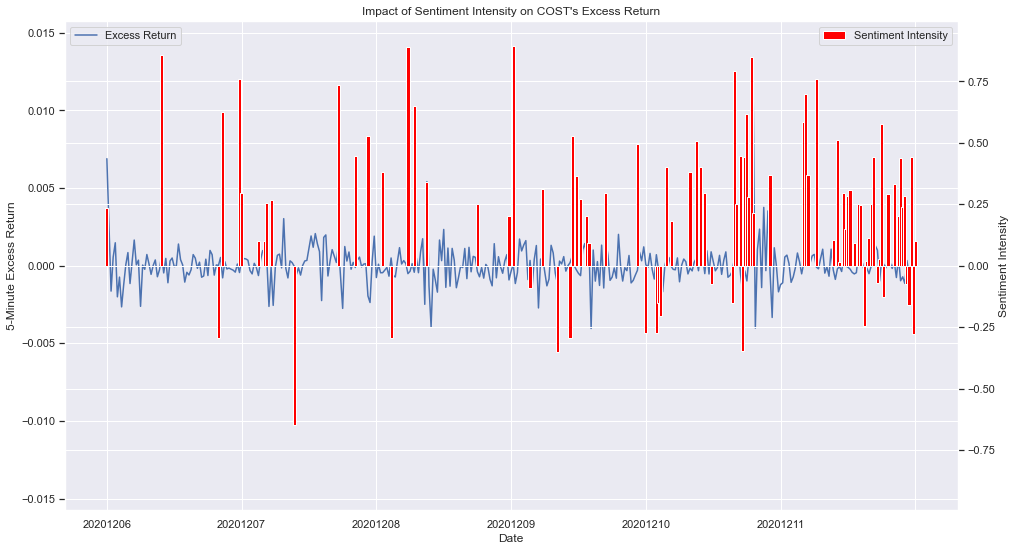

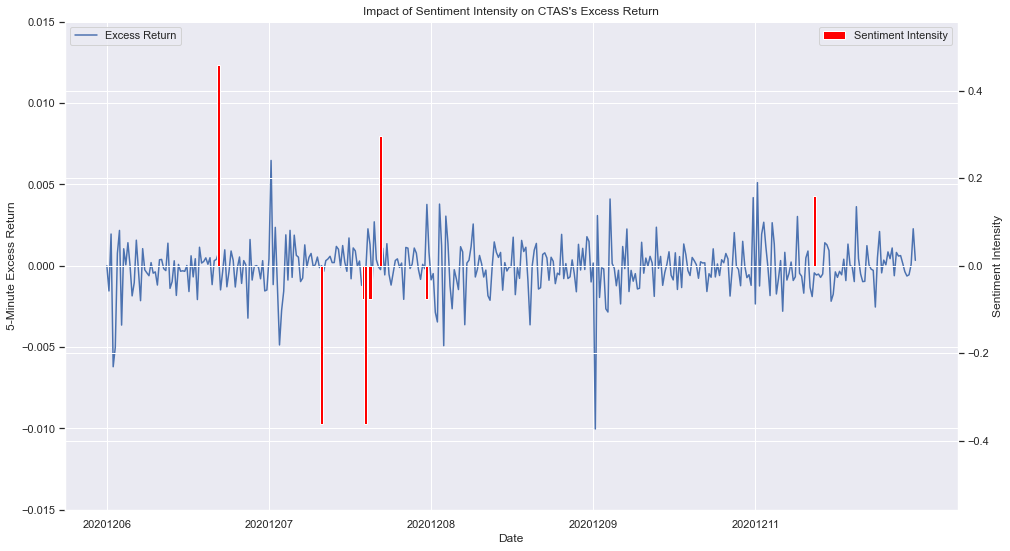

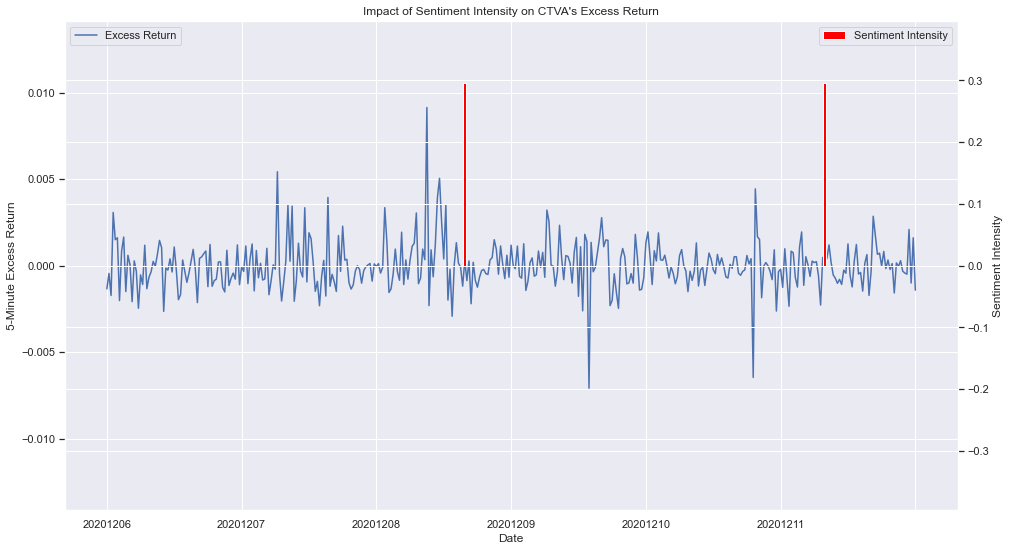

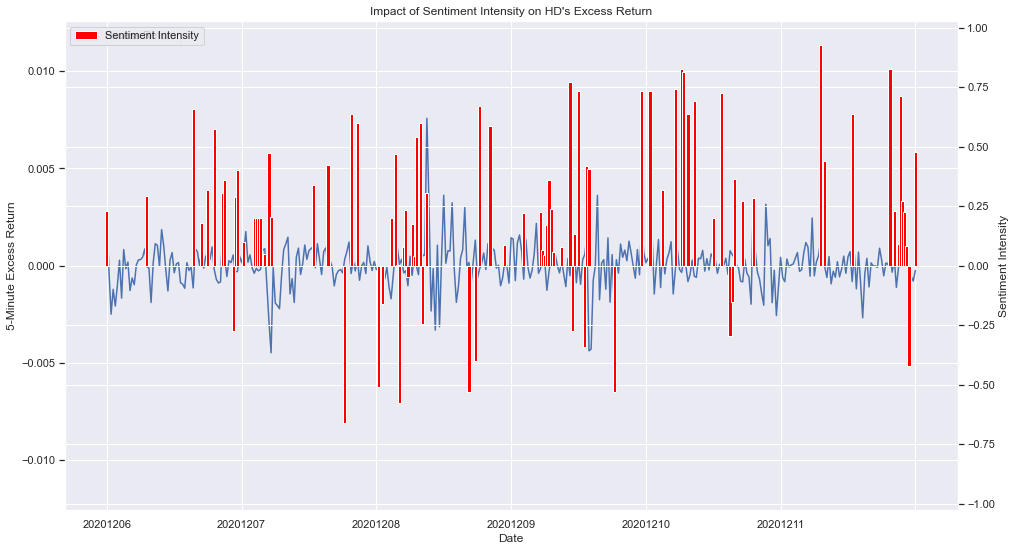

In [29]:
for ticker in ticker_list:
    fig, ax1 = plt.subplots(figsize=(16,9))

    ax2 = ax1.twinx()
    ax1.plot(range(len(price_dict[ticker])),price_dict[ticker].EXCESS_RETURN.values, label='Excess Return')
    ax2.bar(range(len(price_dict[ticker])),price_dict[ticker].AVE.values, color='red',width=1.5, label='Sentiment Intensity')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('5-Minute Excess Return')
    ax2.set_ylabel('Sentiment Intensity')

    plt.xticks(range(0,len(price_dict[ticker]),int(len(price_dict[ticker])/len(list(set(all_dates[ticker]))))),sorted(list(set(all_dates[ticker]))))

    ax1.legend(loc=2)
    ax2.legend()
    
    ax1.set_ylim(-max(abs(price_dict[ticker].EXCESS_RETURN.values))-0.005,max(abs(price_dict[ticker].EXCESS_RETURN.values))+0.005)
    ax2.set_ylim(-max(abs(price_dict[ticker].AVE.values))-0.1,max(abs(price_dict[ticker].AVE.values))+0.1)

    plt.title("Impact of Sentiment Intensity on "+ ticker+"'s Excess Return")

    plt.show()

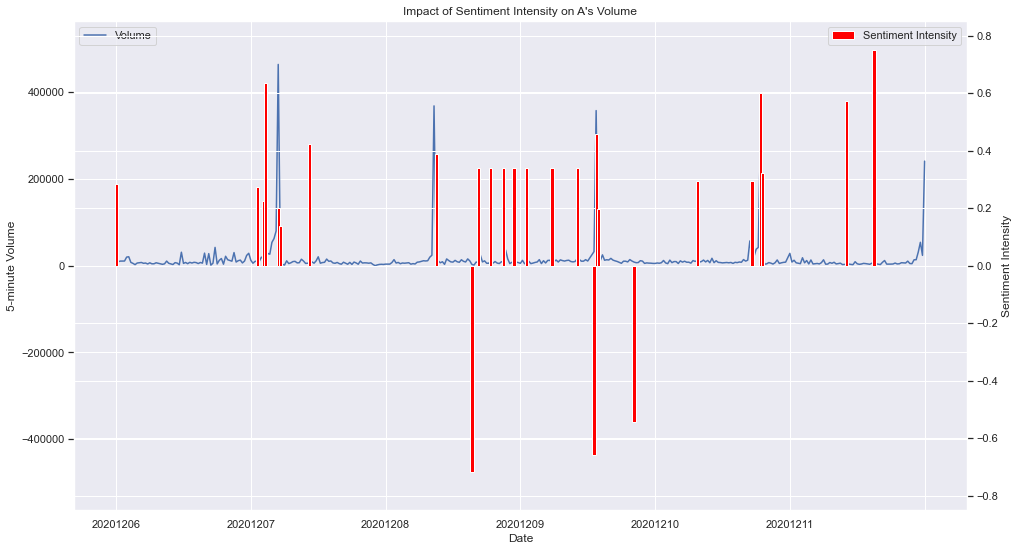

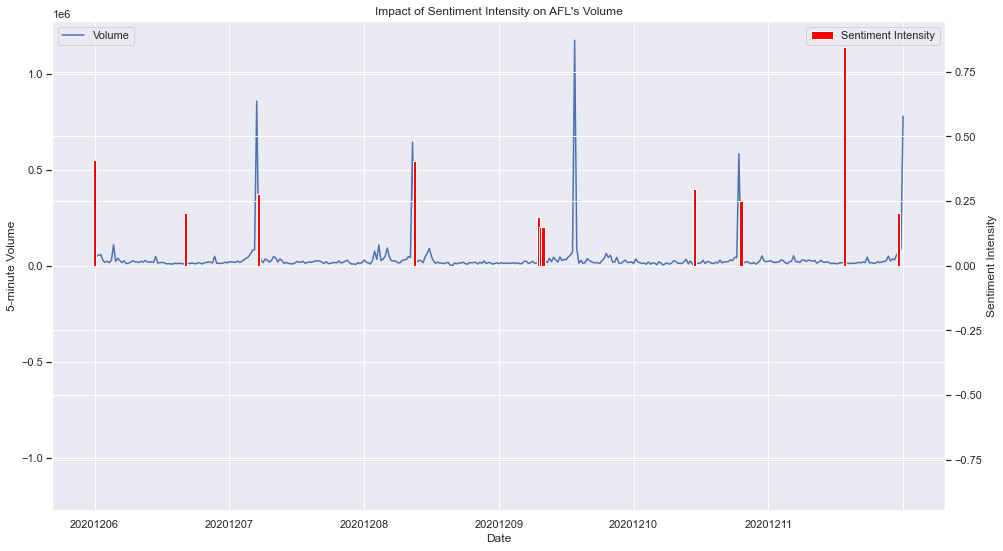

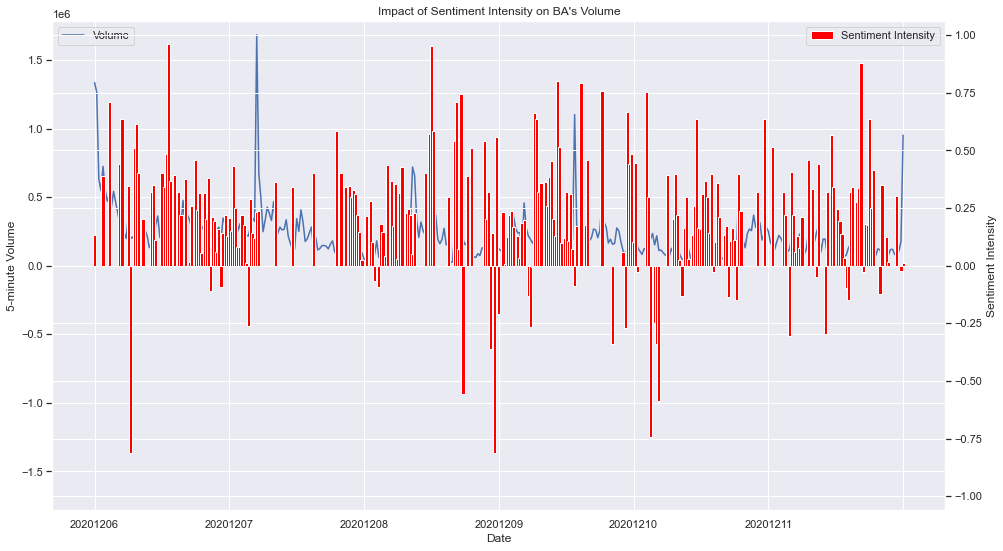

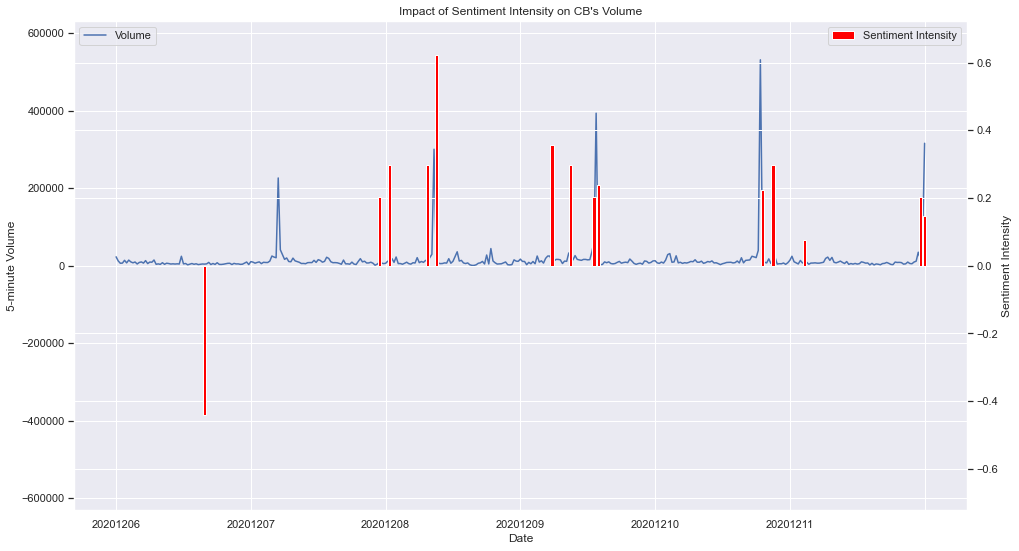

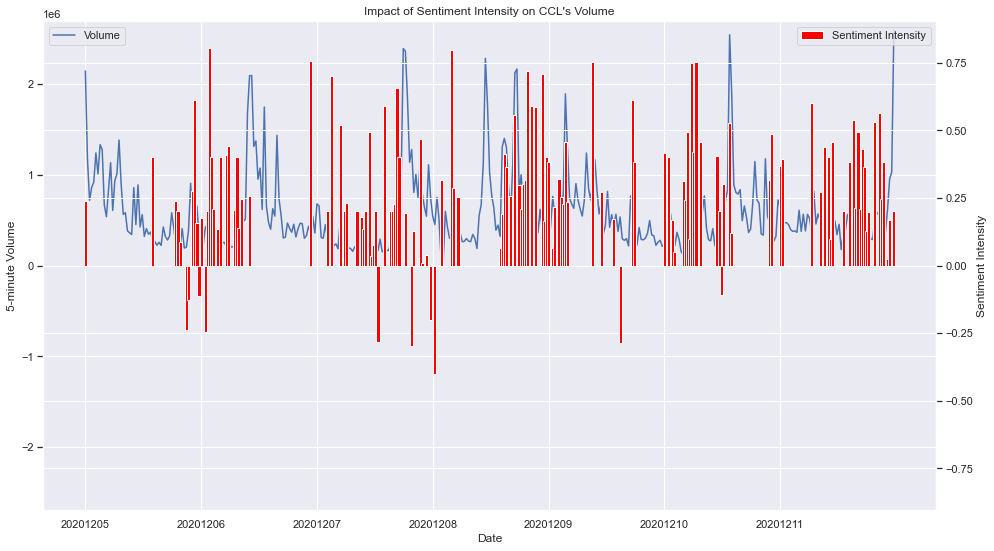

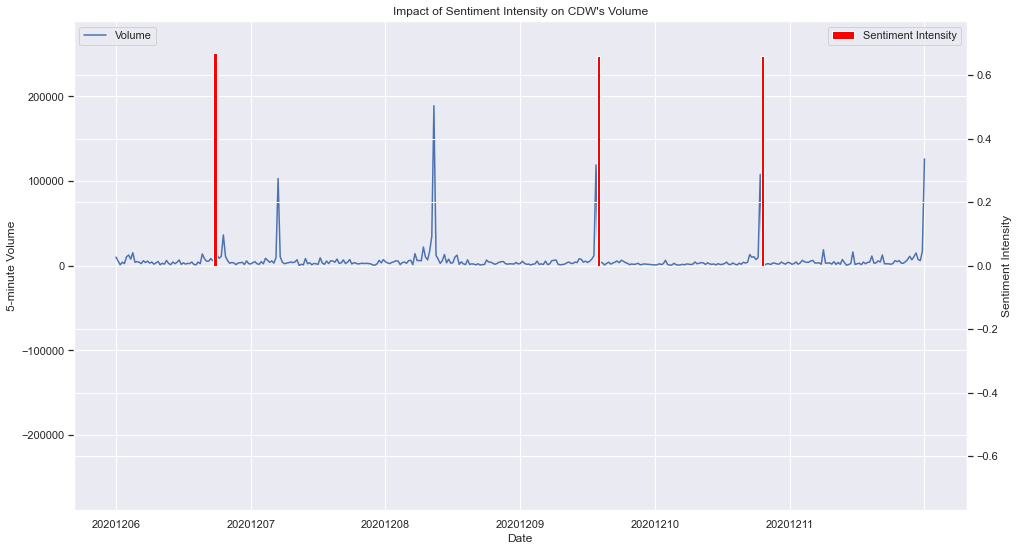

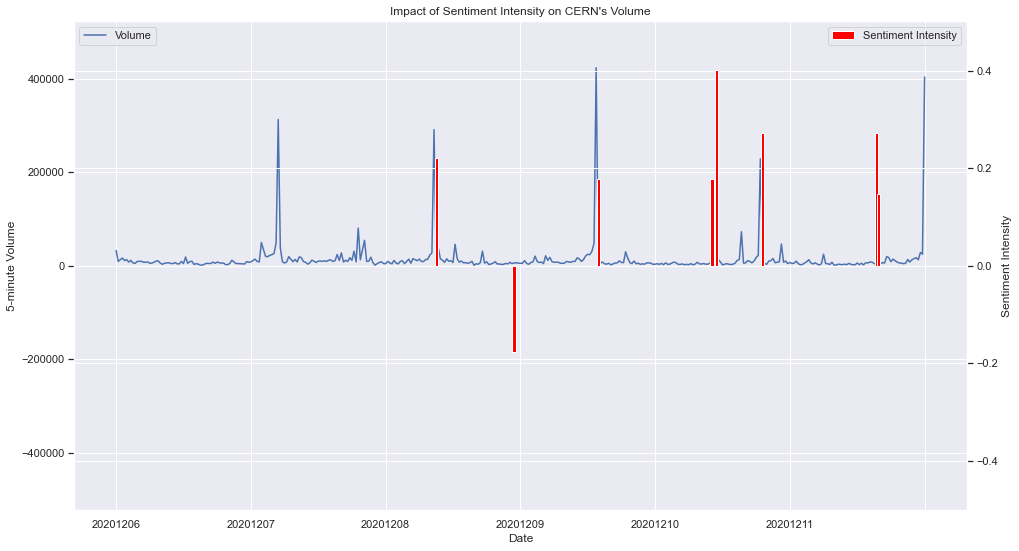

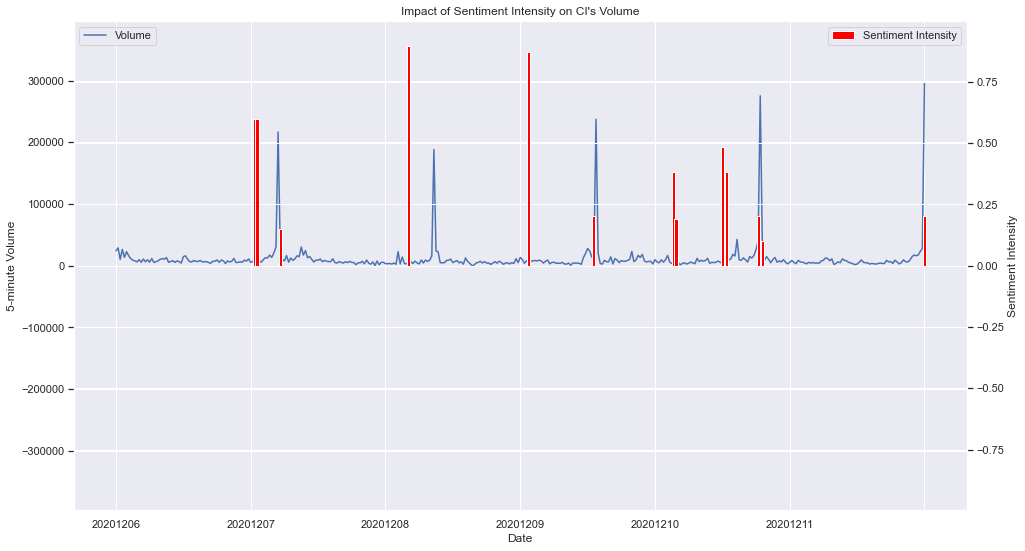

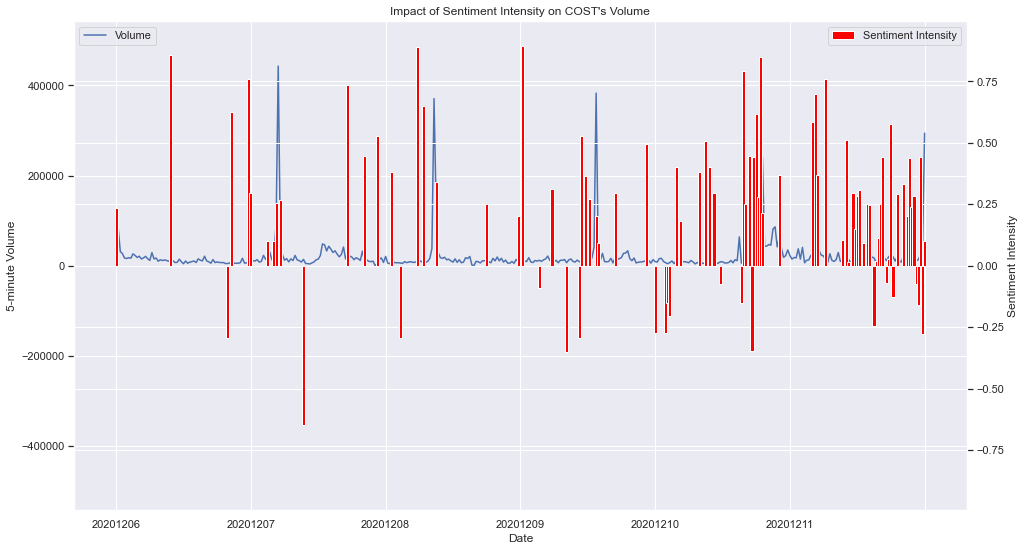

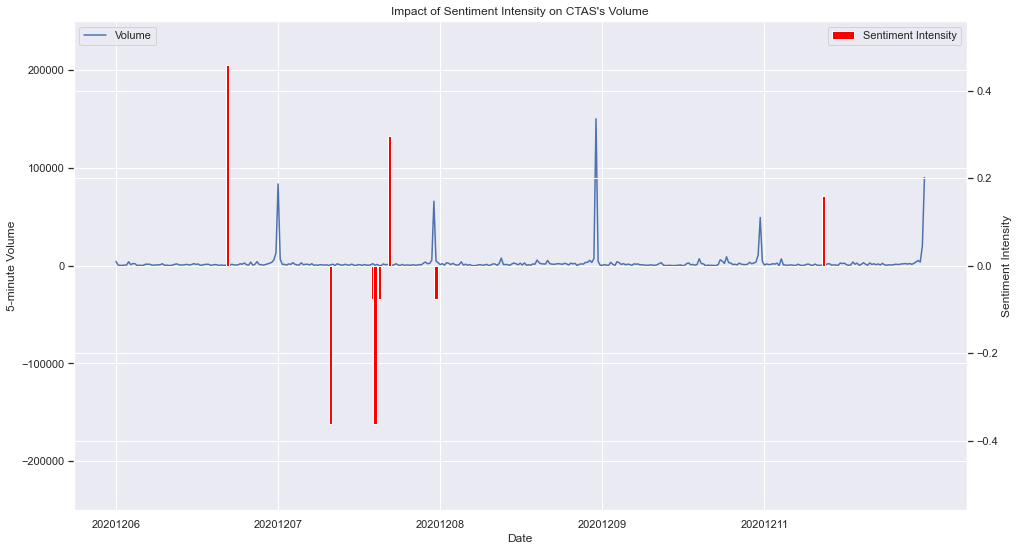

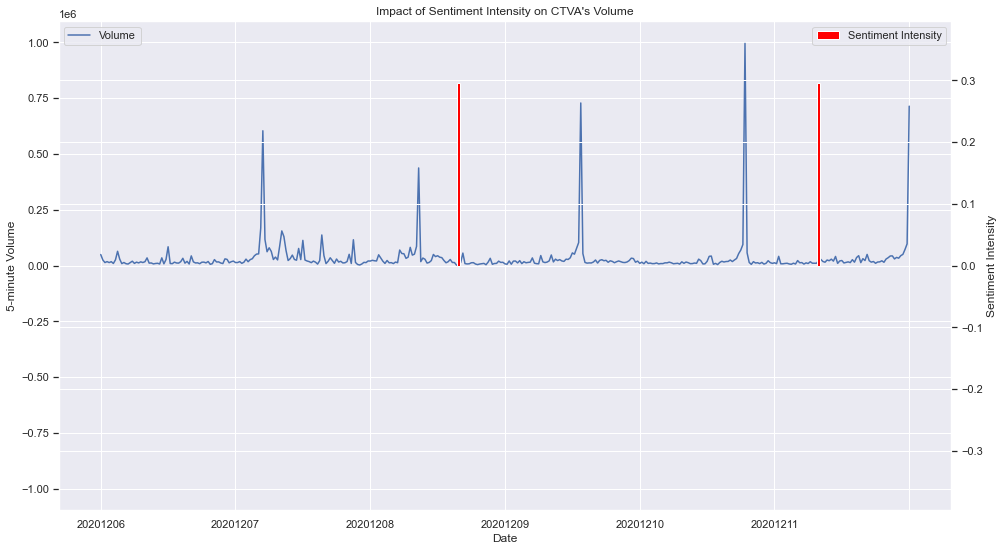

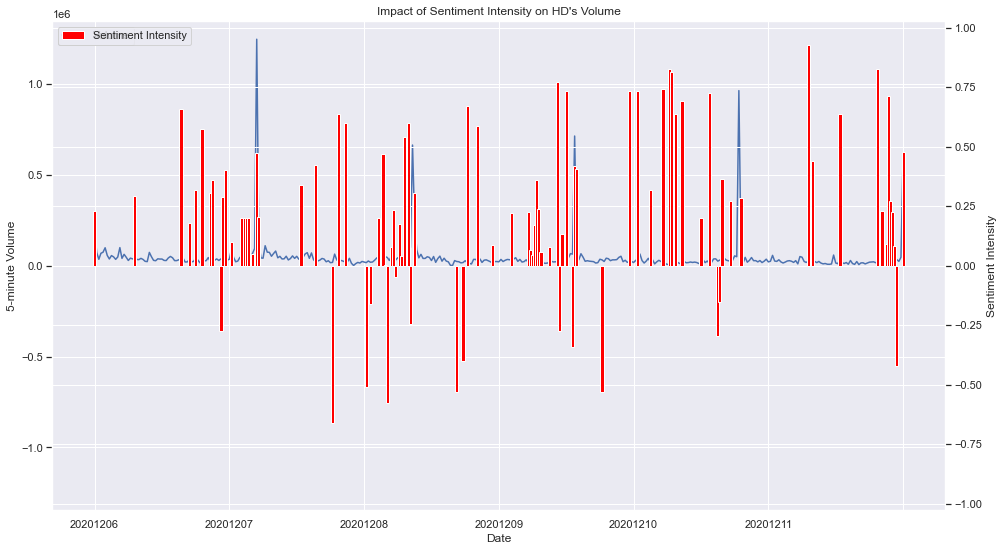

In [30]:
for ticker in ticker_list:
    fig, ax1 = plt.subplots(figsize=(16,9))

    ax2 = ax1.twinx()
    ax1.plot(range(len(price_dict[ticker])),price_dict[ticker].VOL.values, label='Volume')
    ax2.bar(range(len(price_dict[ticker])),price_dict[ticker].AVE.values, color='red',width=1.5, label='Sentiment Intensity')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('5-minute Volume')
    ax2.set_ylabel('Sentiment Intensity')

    plt.xticks(range(0,len(price_dict[ticker]),int(len(price_dict[ticker])/len(list(set(all_dates[ticker]))))),sorted(list(set(all_dates[ticker]))))

    ax1.legend(loc=2)
    ax2.legend()
    
    ax1.set_ylim(-max(abs(price_dict[ticker].VOL.values))-100000,max(abs(price_dict[ticker].VOL.values))+100000)
    ax2.set_ylim(-max(abs(price_dict[ticker].AVE.values))-0.1,max(abs(price_dict[ticker].AVE.values))+0.1)

    plt.title("Impact of Sentiment Intensity on "+ ticker+"'s Volume")

    plt.show()

In [31]:
# compute volatility
# dictionary of dataframes contains volatility
volatility_dict = dict.fromkeys(ticker_list, None)

for ticker in ticker_list:
    cur_df = price_dict[ticker][['LOW', 'HIGH']]
    price_max = cur_df.groupby('DATE').max()
    price_min = cur_df.groupby('DATE').min()
    price_max['LOW'] = price_min['LOW']
    price_max['VOLATILITY'] = 2*(price_max['HIGH'] - price_max['LOW'])/(price_max['HIGH'] + price_max['LOW']) * 100
    price_max.drop(['LOW', 'HIGH'], axis = 1, inplace = True)
    volatility_dict[ticker] = price_max
    volatility_dict[ticker] = volatility_dict[ticker].loc[int(min(all_dates[ticker])):,:]

In [32]:
price_dict['A']

OPEN     HIGH      LOW    CLOSE     VOL   SCORE  NUM  \
DATE     TIME                                                           
20201207 930   115.20  116.440  115.075  116.270   68973  4.5212   16   
         935   116.03  116.040  115.700  115.860    9184  0.0000    0   
         940   116.00  116.155  115.450  115.520   10577  0.0000    0   
         945   115.49  115.490  115.145  115.180   10695  0.0000    0   
         950   115.20  115.325  115.180  115.235   10712  0.0000    0   
...               ...      ...      ...      ...     ...     ...  ...   
20201211 1535  118.69  118.820  118.690  118.780   13726  0.0000    0   
         1540  118.78  119.060  118.760  118.870   31495  0.0000    0   
         1545  118.79  119.029  118.460  118.460   53930  0.0000    0   
         1550  118.46  118.650  118.430  118.530   23790  0.0000    0   
         1555  118.54  118.680  118.380  118.480  241113  0.0000    0   

                    AVE  EXCESS_RETURN  
DATE     TIME                           
20201207 930   0.282575       0.011710  
         935   0.000000      -0.003072  
         940   0.000000      -0.003752  
         945   0.000000      -0.002853  
         950   0.000000       0.001074  
...                 ...            ...  
20201211 1535  0.000000       0.000519  
         1540  0.000000       0.001031  
         1545  0.000000      -0.002635  
         1550  0.000000      -0.000010  
         1555  0.000000      -0.000668  

[385 rows x 9 columns]

In [33]:
volatility_dict['A']

,VOLATILITY
DATE,
20201207,2.012491
20201208,2.598524
20201209,2.125637
20201210,3.005545
20201211,1.497779


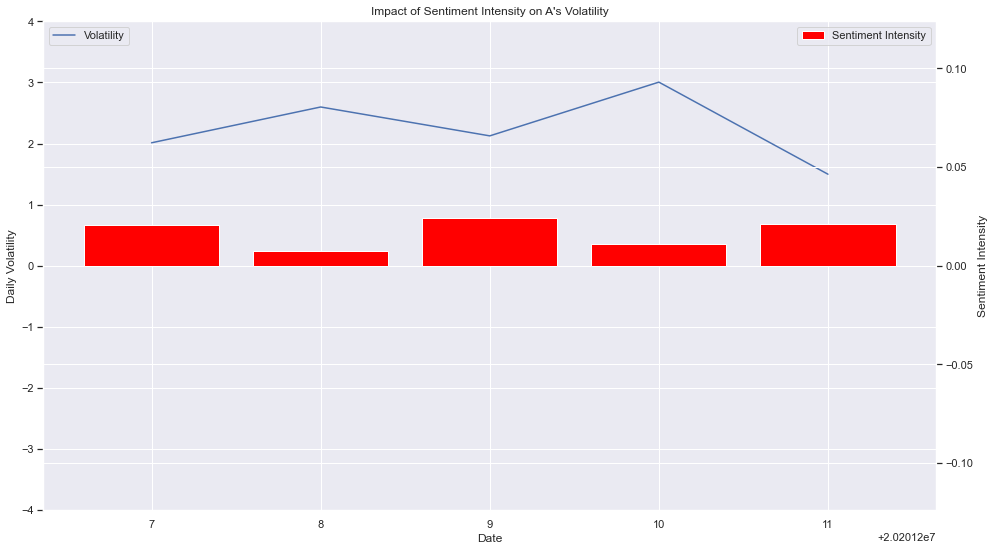

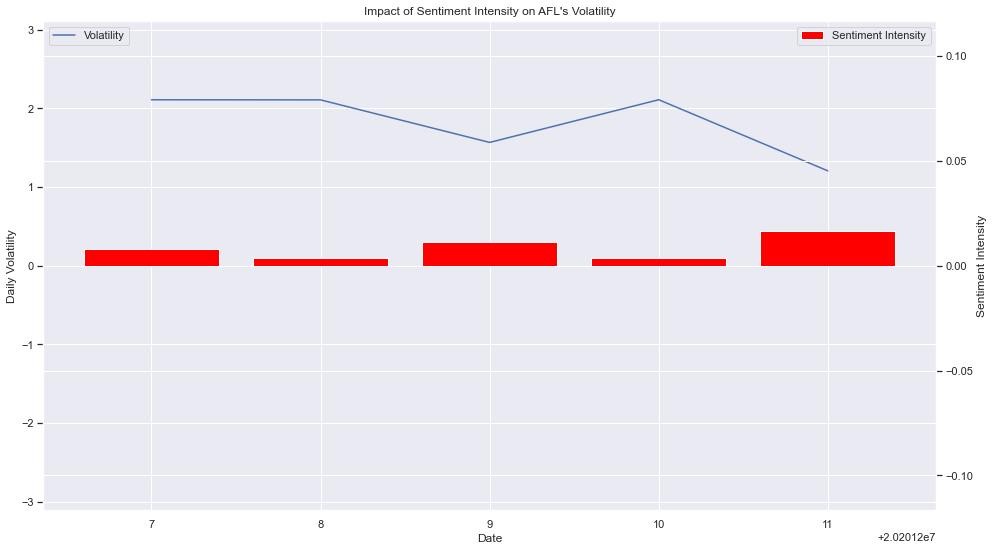

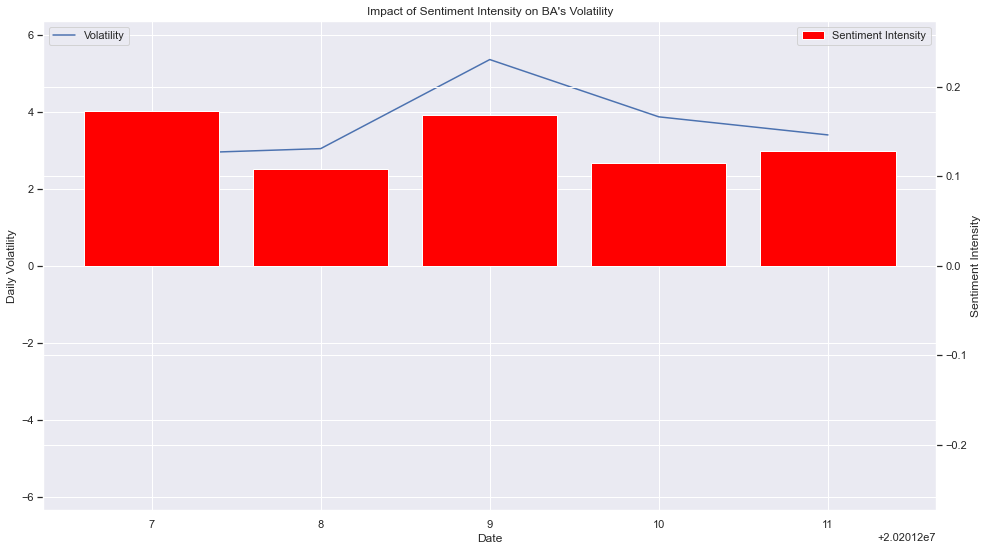

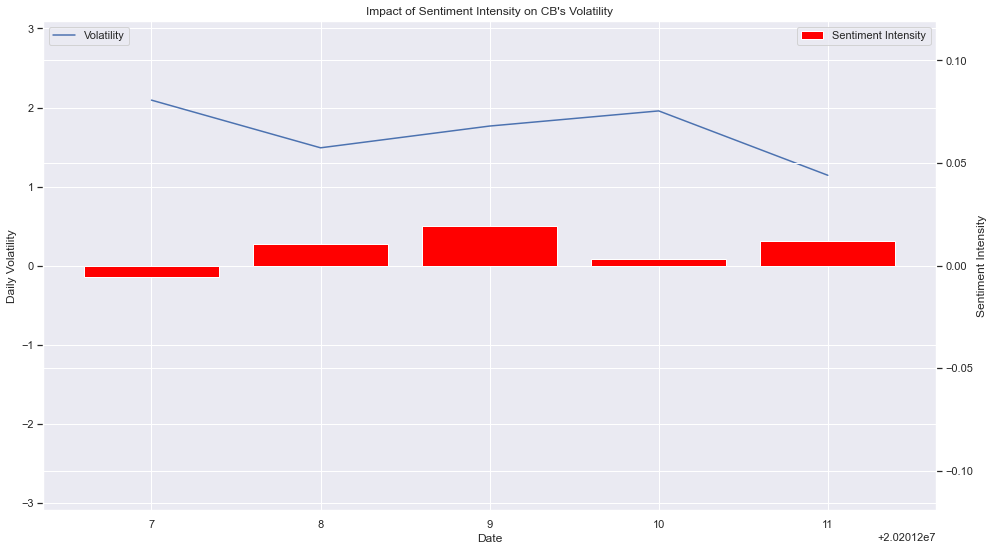

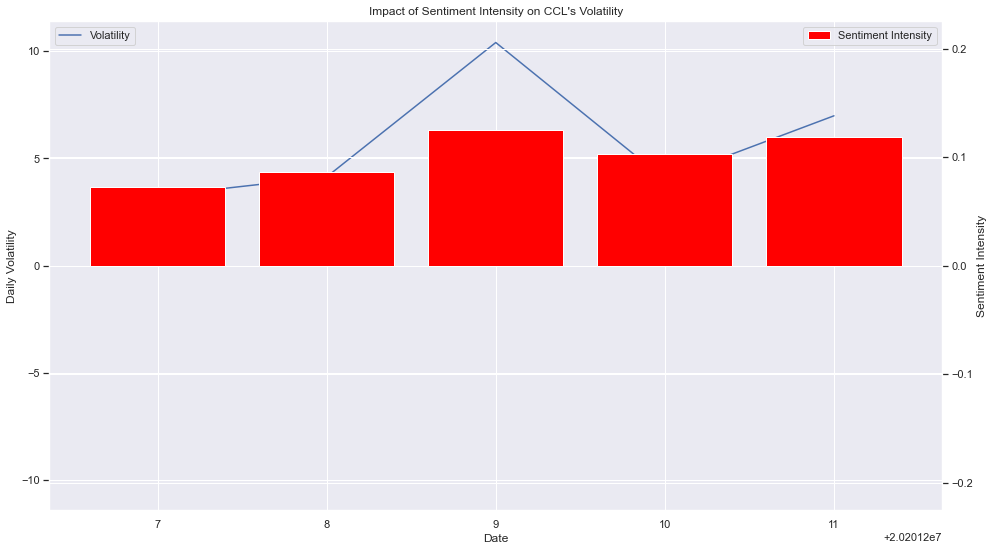

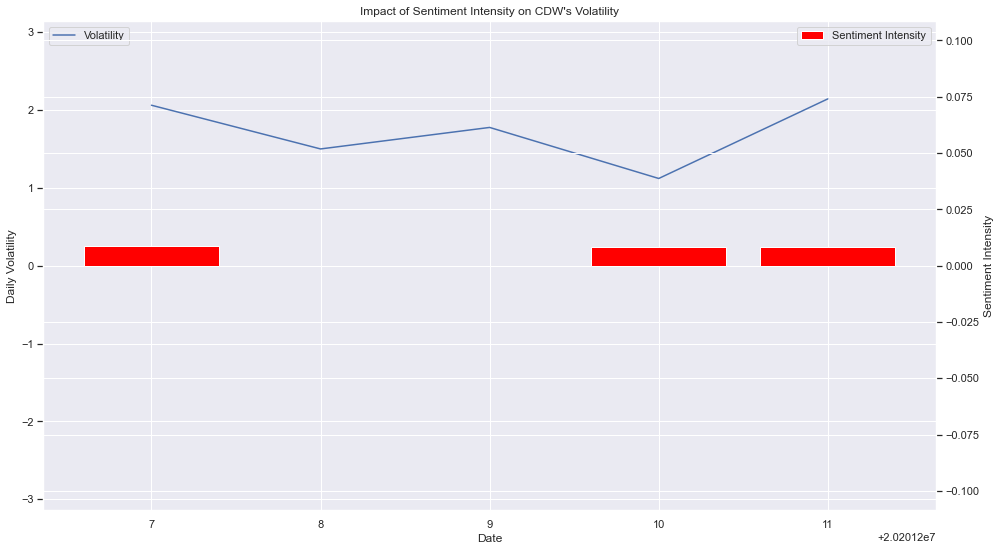

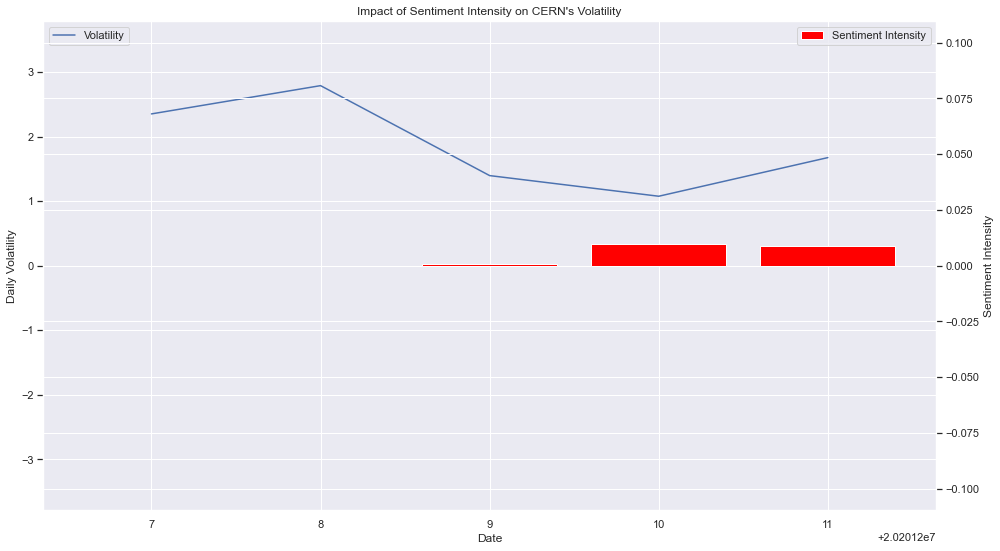

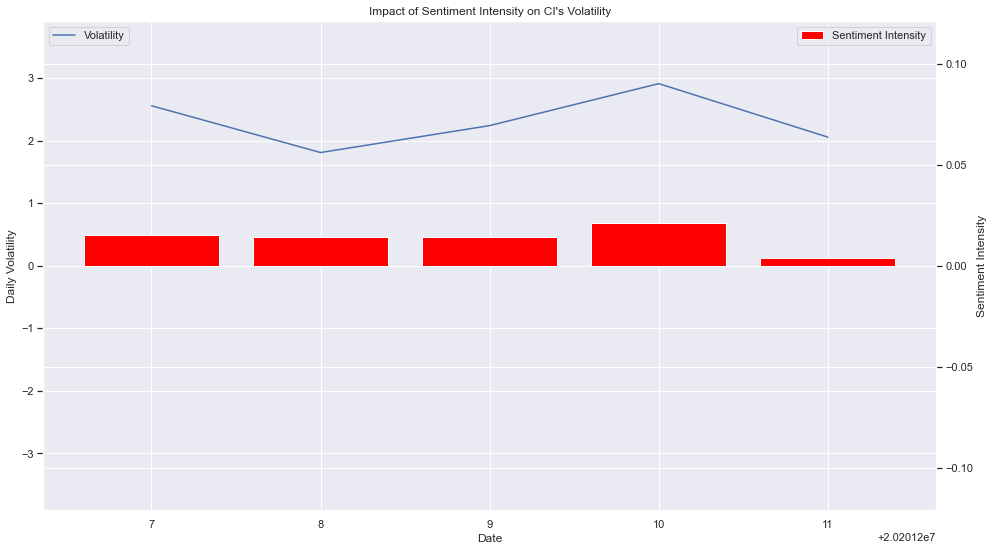

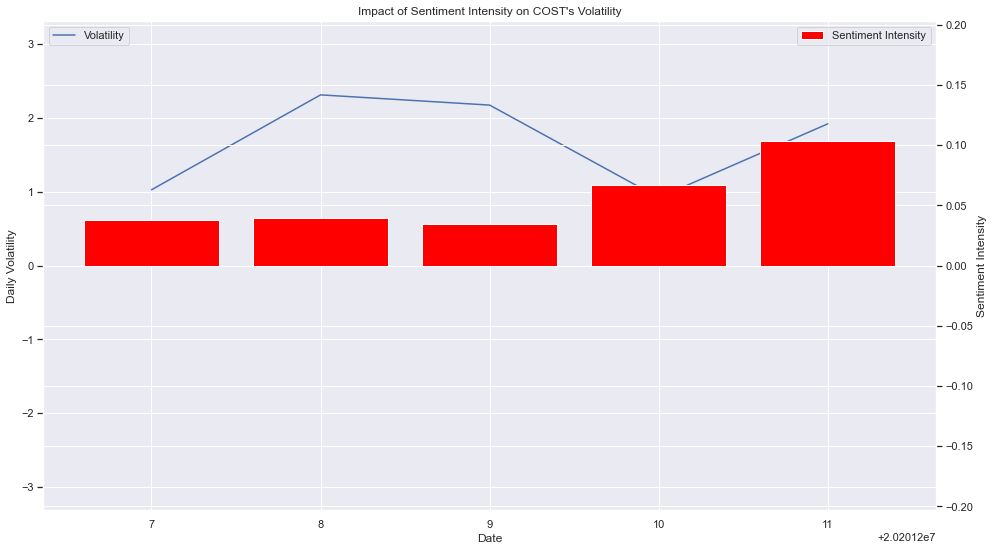

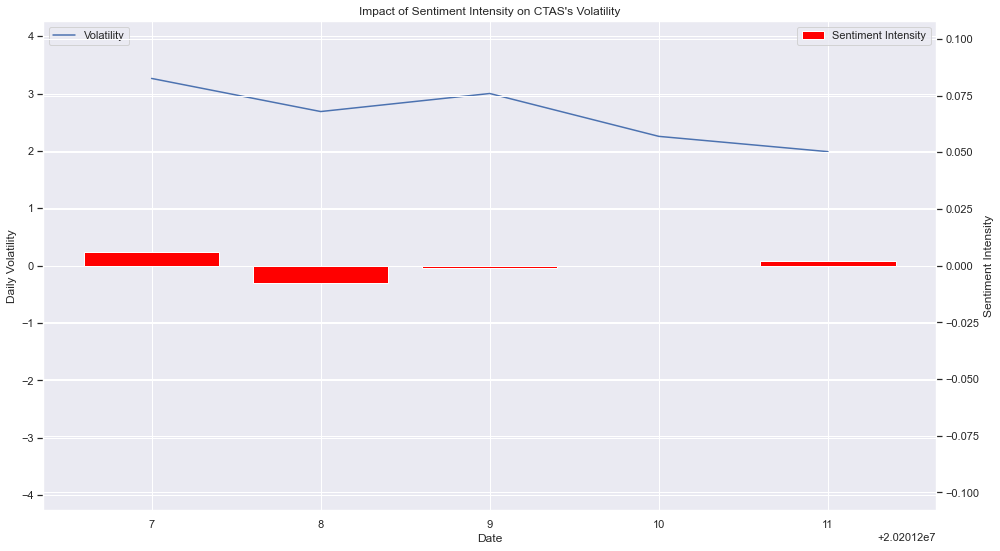

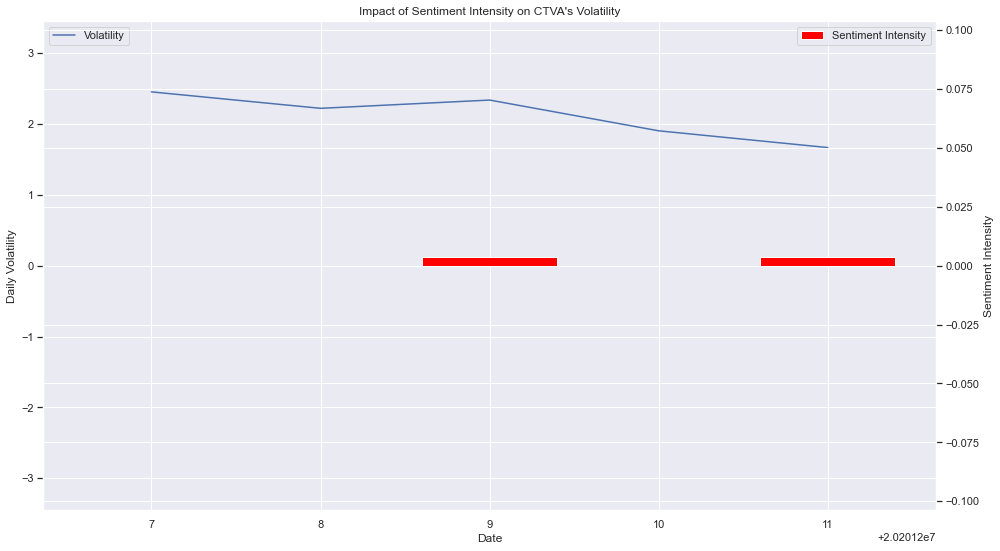

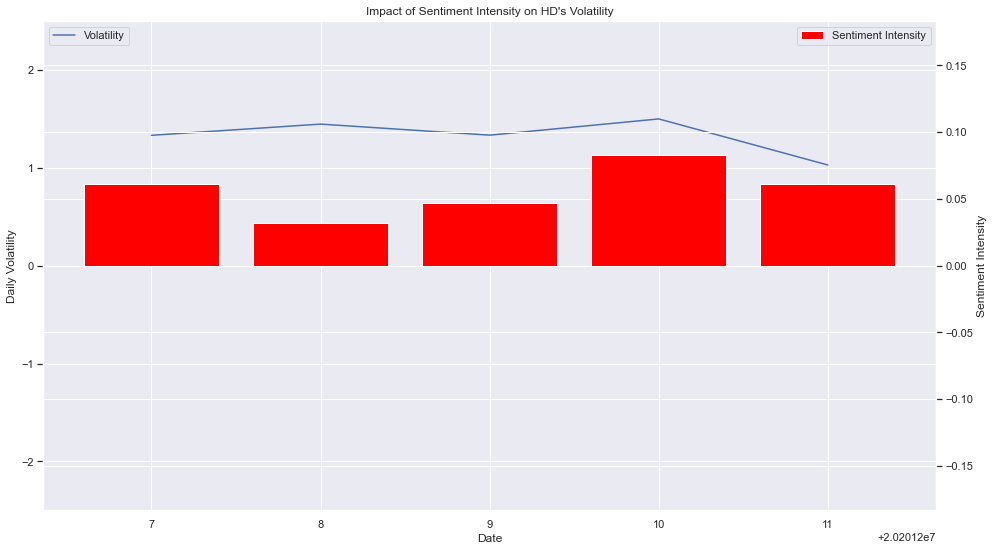

In [34]:
for ticker in ticker_list:
    
    daily_sentiment = [np.mean(price_dict[ticker].loc[date,'AVE']) for date in list(volatility_dict[ticker].index)]
    
    fig, ax1 = plt.subplots(figsize=(16,9))

    ax2 = ax1.twinx()
    ax1.plot(list(volatility_dict[ticker].index),volatility_dict[ticker].VOLATILITY.values, label='Volatility')
    ax2.bar(list(volatility_dict[ticker].index),daily_sentiment, color='red', label='Sentiment Intensity')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Volatility')
    ax2.set_ylabel('Sentiment Intensity')

#    plt.xticks(range(0,len(price_dict[ticker]),int(len(price_dict[ticker])/len(list(set(all_dates[ticker]))))),sorted(list(set(all_dates[ticker]))))

    ax1.legend(loc=2)
    ax2.legend()
    
    ax1.set_ylim(-max(abs(volatility_dict[ticker].VOLATILITY.values))-1,max(abs(volatility_dict[ticker].VOLATILITY.values))+1)
    ax2.set_ylim(-max(abs(np.array(daily_sentiment)))-0.1,max(abs(np.array(daily_sentiment)))+0.1)

    plt.title("Impact of Sentiment Intensity on "+ ticker+"'s Volatility")

    plt.show()

In [35]:
all_stats = []
for ticker in ticker_list:
    stats = []
    temp_df = price_dict[ticker][price_dict[ticker].AVE != 0]
    daily_sentiment = [np.mean(price_dict[ticker].loc[date,'AVE']) for date in list(volatility_dict[ticker].index)]
    temp_vol = volatility_dict[ticker][np.array(daily_sentiment) != 0]
    stats.append(np.mean(temp_df.AVE))
    stats.append(np.mean(temp_df.EXCESS_RETURN))
    stats.append(np.mean(temp_df.VOL))
    stats.append(np.mean(temp_vol.VOLATILITY))
    all_stats.append((ticker,stats))
all_stats = dict(all_stats)

### Part 2 Result - Summary Table of Sentiment, Excess Return, Volume, and Volatility Across All Stocks

In [36]:
result = pd.DataFrame(all_stats)
result.index = ['Average Sentiment Intensity','Averegae Excess Return','Average Volume','Average Volatility']
result

,A,AFL,BA,CB,CCL,CDW,CERN,CI,COST,CTAS,CTVA,HD
Average Sentiment Intensity,0.250630,0.306364,0.222497,0.215291,0.291293,0.663300,0.186784,0.404896,0.245081,-0.005013,0.296000,0.250054
Averegae Excess Return,0.000723,-0.000271,0.000049,0.001162,-0.000324,0.001371,0.000820,-0.000293,0.000238,0.000512,0.000284,0.000182
Average Volume,56264.076923,37897.545455,200180.016667,39802.642857,565995.246269,8063.000000,10593.000000,34999.307692,32009.786517,1360.375000,12330.500000,66427.181818
Average Volatility,2.247995,1.819694,3.711188,1.690134,5.759124,1.775257,1.381295,2.314163,1.672245,2.734952,2.002983,1.328113


# Part 3: Conclusion of the Project

- **Kernal density distribution:** The sentiments' kernel density distributions of those 12 stocks show more density around neutral sentiment point 0, which is not super surprising. More insightful observation is that tweets related to most of the 12 companies have higher densities in positive sentiments than in negative sentiments. One plausible explanation of the phenomenon would be the emerging of COVID-19 vaccines, which relieve people's panic about the economy and drive them to post more positive tweets than negative ones. Overall, the density distributions of those stocks can reflect some of people's views on the market.
<br><br>
- **Sentiments' impact on excess returns:** In general, we observe there are two different ways of interpreting the relationship between sentiments’ intensities and excess returns. One of the relationships is sentiments imposing impacts on the market. As shown in AFL excess return plot, the first sentiment with intensity of 0.4 (first red bar from the left) has driven the excess return of AFL from -0.65% to a positive number in 5-minute period. This example illustrates that market can react quickly if there are some strong sentiments around. However, we can also interpret the relationship another way around, which is people are talking about stocks’ historical performance via Twitter. An example could be CTVA’s excess return plot. In this plot, there is one tweet having sentiment intensity about 0.3 in the middle of the 2012/12/08 trading hours, and we can guess this tweet was probably talking about CTVA’s strong performance a few hours ago as there was no strong performance followed. Since the relationship between sentiments’ intensities and excess returns can be described in both ways, Twitter sentiment analysis cannot be used as tool for generating consistent excess returns unless the analysis can incorporate methods of detecting whether those tweets are talking about historical performance or some new information/outlook. 
<br><br>
- **Sentiments' impact on volumes:** The impact of sentiment intensity on volume is fairly significant in general. In particular, stocks with relatively lower volume are more sensitive to positive or negative twitters; whenever there exists a directional twitter, the volume goes up closely. In contrast, the impact of sentiment intensity on volume is not that notable for the stocks with high liquidity in the market. Since those stocks are always hot issues, such as BA, CCL, and HD mentioned above, the twitter sentiment intensity does not influence investors decisions greatly.
<br><br>
- **Sentiments' impact on volatilities:** The impact of sentiment intensity on volatilities varies markedly for stocks we studied. In other words, there does not exist a discernable relationship between sentiment intensity and volatility in the market. To be more specific, stocks with continuously high volatilities are more sensitive with twitter sentiments than those with low volatilities. Based on our case, both BA and CCL will have higher volatilities when their sentiment intensity is positive, which  matches our expectations. On the other hand, for the stocks that are not volatile in general, the twitter sentiment intensity do not impact the volatilities adequately. Surprisingly, the volatilities of CERN are even lower when there existed positive twitter sentiments. Hence, the impact of sentiment intensity on volatilities does not exist observable relationships. 
<br><br>
- **Summary Table:** In the table above, we estimate 7-day average score of sentiment intensity, excess return, volume, volatility for these 12 companies. By analyzing the relationship of sentiment with other 3 features, we find that overall there is no realtion between sentiment and other features in 7-day average data. In the intraday analysis above, sentiment intensity has impact on other 3 features, but such impact is not seen in 7-day average data indicating that such impact are only short-term impact.
<br><br>
- **Limitations:** Despite some of the insightful conclusion drawns from this project, we believe the result can be more significant through several improvement. One way we can improve our analysis is to use a different dictionary for our sentiment analysis. Even though the VADER dictionary has sentiment intensity, we observe the dictionary can perform poorly on some of the words. For example, the dictionary gives the word "down" a score of 0, which usually doesn't make sense. Another example can be the word "development" which is given a score of 0 again, but in our context, a company making a new development on its products should be a positive news. Hence, a more well-built dictionary can be used to build a more accurate model. Another improvement can change the way we collect relevent tweets. Currently, we search tweets by finding matched keywords, but some of the tweets we collect are not exactly relevent to what we are looking for. For example, a financial official account may post something like "The December market has opened" and tag lots of irrelevent stocks. Such kind of tweets can only bring noises to our analysis without any help, and we find lots of tweets we collect are similar to this one. Hence, to improve our analysis accuracy, we might need to find a better way to filter out noisy tweets when we are collecting useful ones.